# Modeling SyriaTel’s Churn Rate
Hunter Owen, Oz Ahmed, Karim Oliver

# Project overview

The goals of this project was to provide the best model at predicting whether a customer will leave or not from the Syriatel Telecommunications company. 
Being such a competetive market and the recent access of communicating with people across the globe freely, Telecom companies are doing there best to retain customers. 
Along with a model that successfully predicts churn, we would like offer guidance as to what are the biggest features impacting customer churn. 
Our model should focus on predicting as many People who are leaving as possible which means trying to reduce false negatives(predicts them to stay, but they leave). This would give SyriaTel the chance to intervene and offer them deals that could get them to stay and reduce churn. 

# Data

The data we used can be found at [Kaggle](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset)

The Target we are trying to predict is the churn and it has a high class embalance favoring people staying. 85% of the data set is people who statey and only 15% is people who left. Some of features included in this data are state, customer service calls, international plan, minutes, ect. 

The dataframe in this repo can be found [Here](../../src/data/syriatel_customer_churn.csv).

It was 3333 rows by 21 columns with 0 NaNs or duplicates.

# Goal

* Gather useful information from the dataset that can influence buissness decisions by SyriaTel
* Create a Model that can Predict churn with high recall score(focus on having least amount of false negatives). 

# Final Model & Results


#### Model: XGBoost Classifier
>Parameters:                                     
> * learning_rate = 0.01
> * max_depth = 4 
> * n_estimators = 500 
> * gamma = 0.3

>Pipeline:                                     
> * OneHotEncoder
> * StandardScalar
> * SMOTE

#### Recall of 84% on hold out test.

Out of 101 people who left the company our model predicted 85 correctly<br>
Out of 566 people who stayed with the company our model predicted 548 correctly

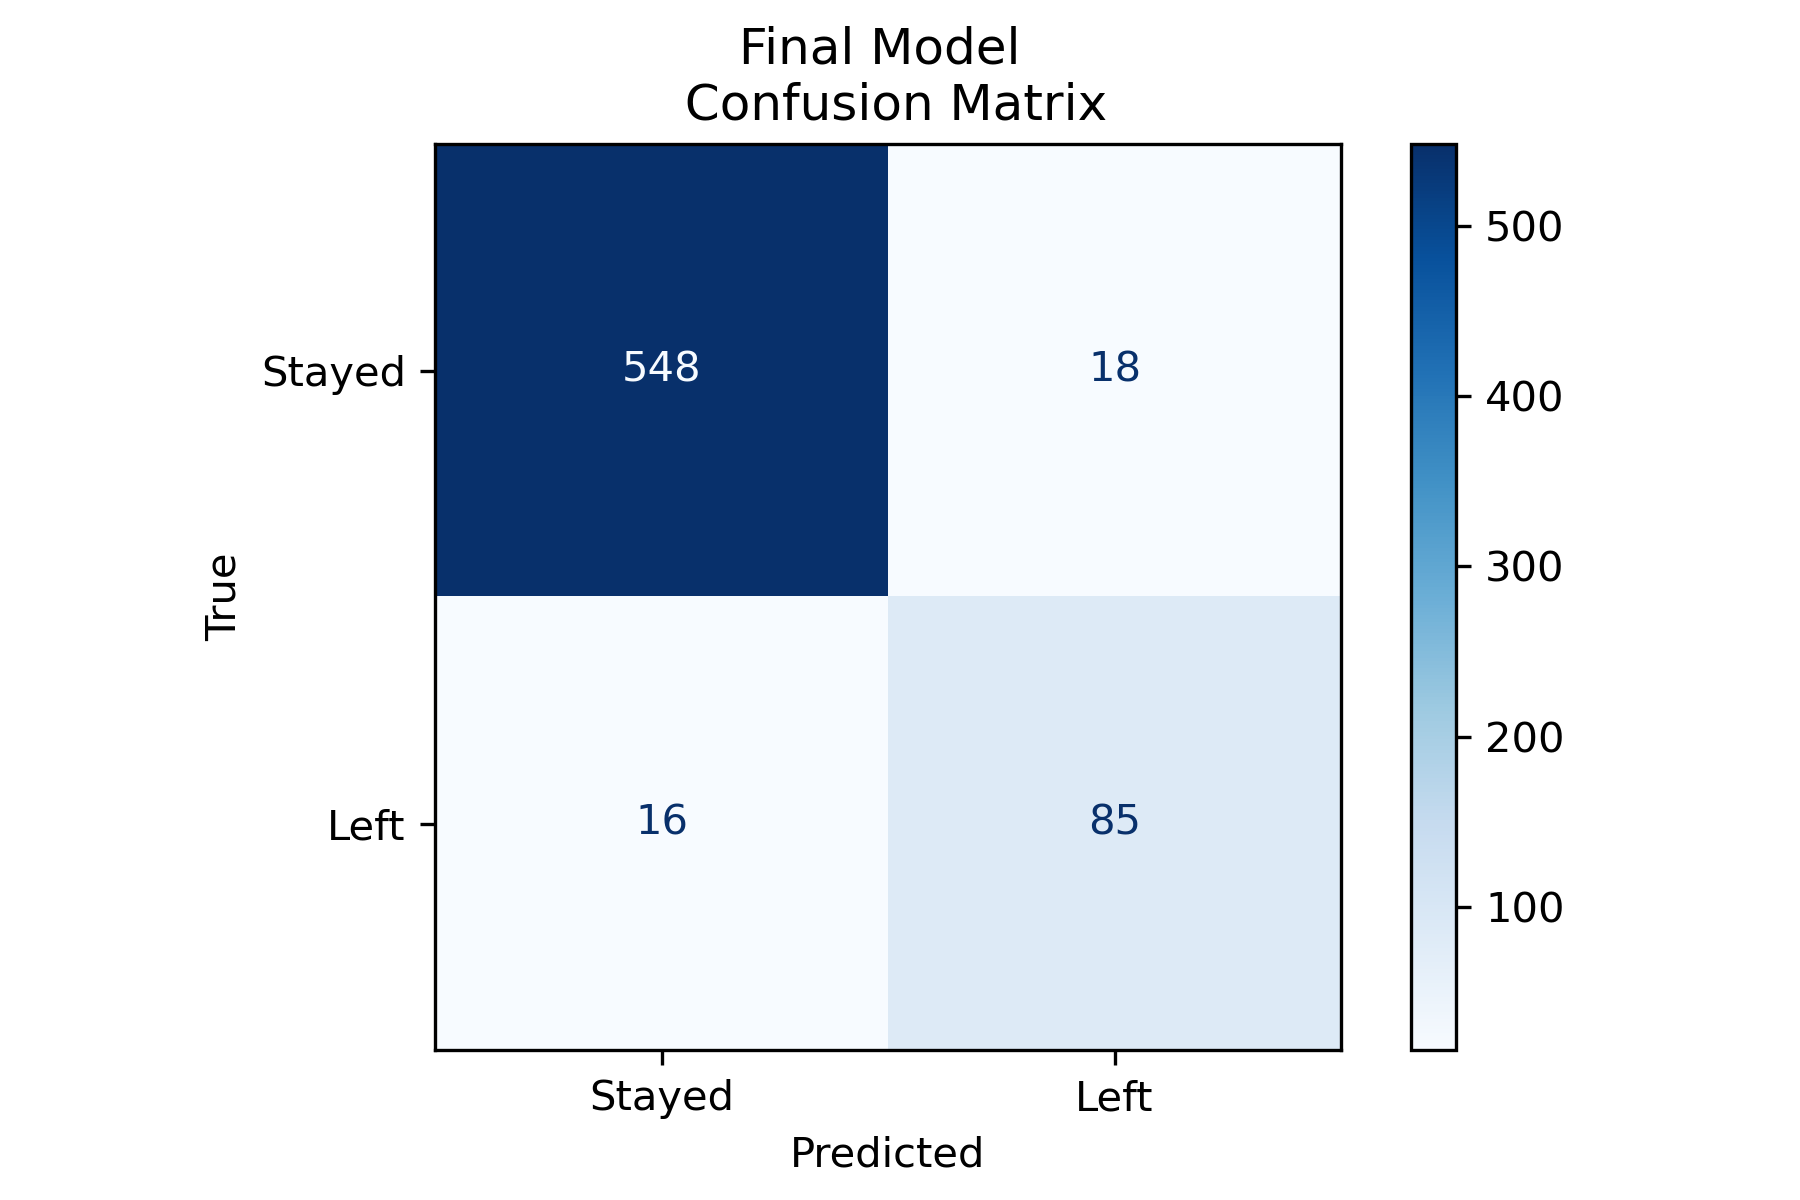

In [26]:
Image(filename = "figures/final_model.png", width = 600, height = 300)

# Imports

In [ ]:
#For dataframe and graphing
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

#Scikit learn libary and other similar one
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer, make_column_transformer
from xgboost import XGBClassifier 
import xgboost as xgb
import scipy

# For reading in custom functions
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Custom function
from src.mymods import model_output
%matplotlib inline

# Exploring the Data and Features 

In [76]:
df = pd.read_csv('../../src/data/syriatel_customer_churn.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


The Churn rate for people with Internation plans was far higher than those without as shown in the graph below. This would be a good feature to use in our model

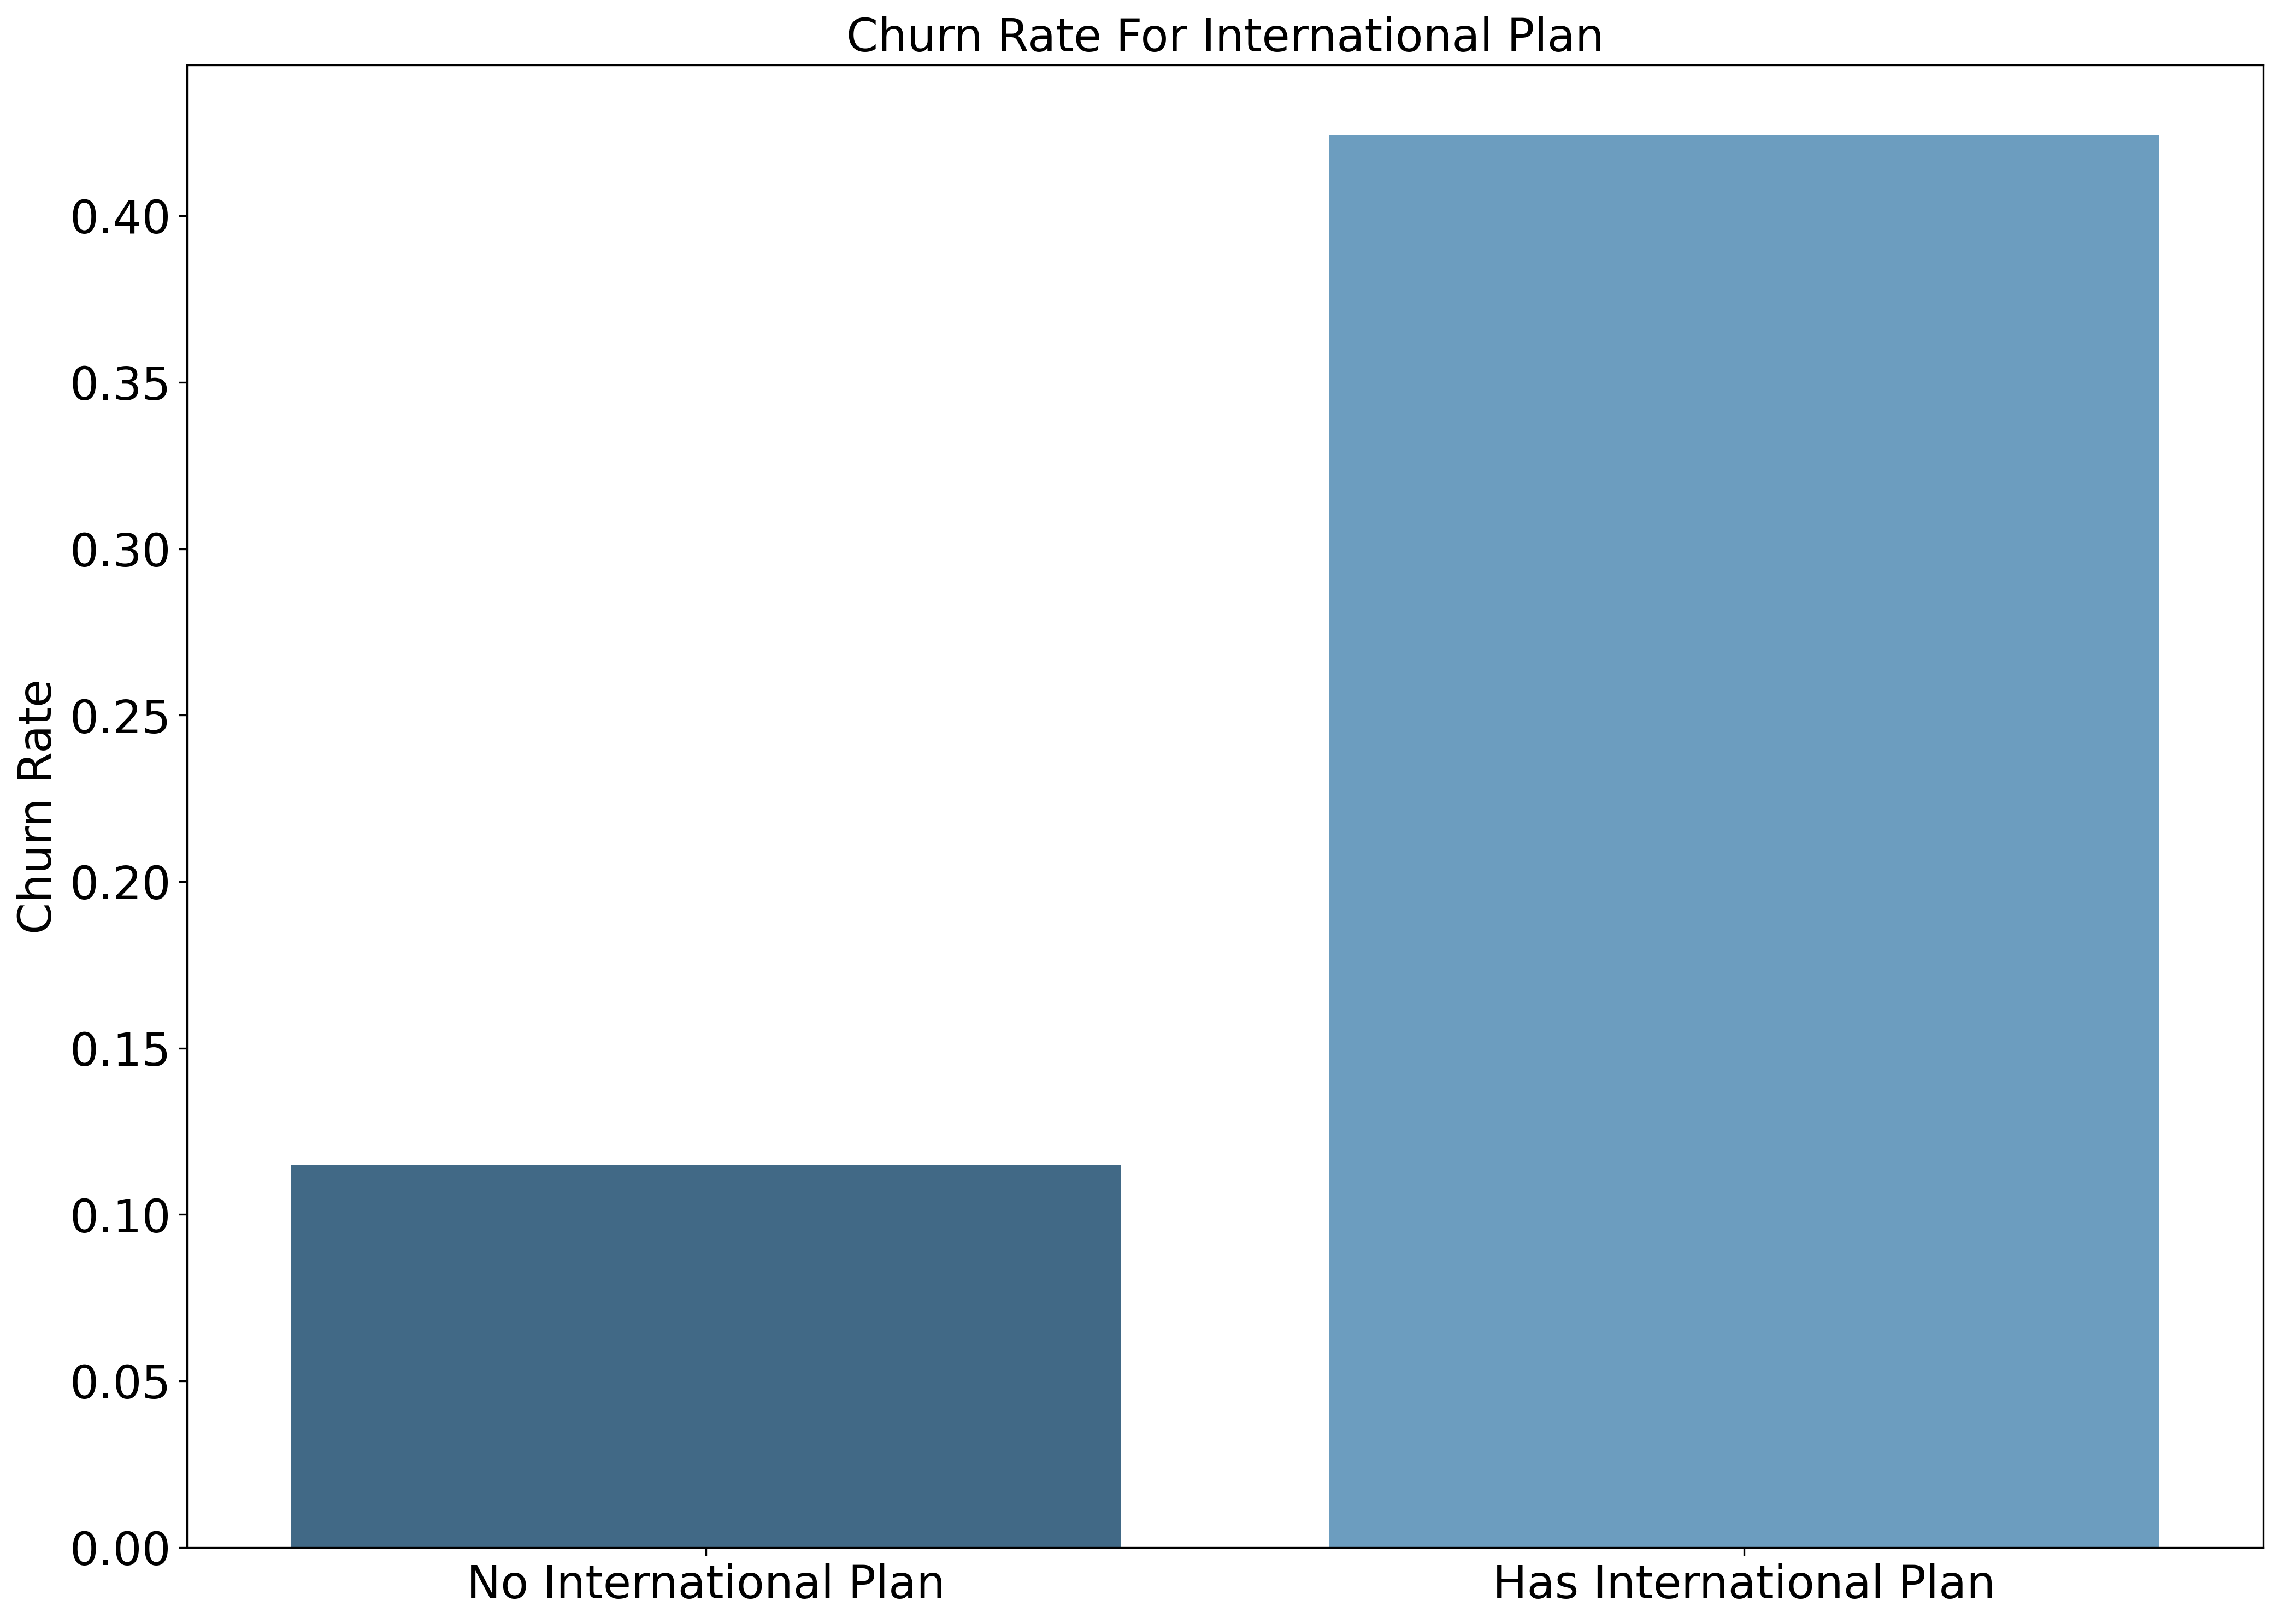

In [27]:
Image(filename = "figures/Internationalplan.png", width = 600, height = 300)

As customer Calls increased so did the churn rate which made sense

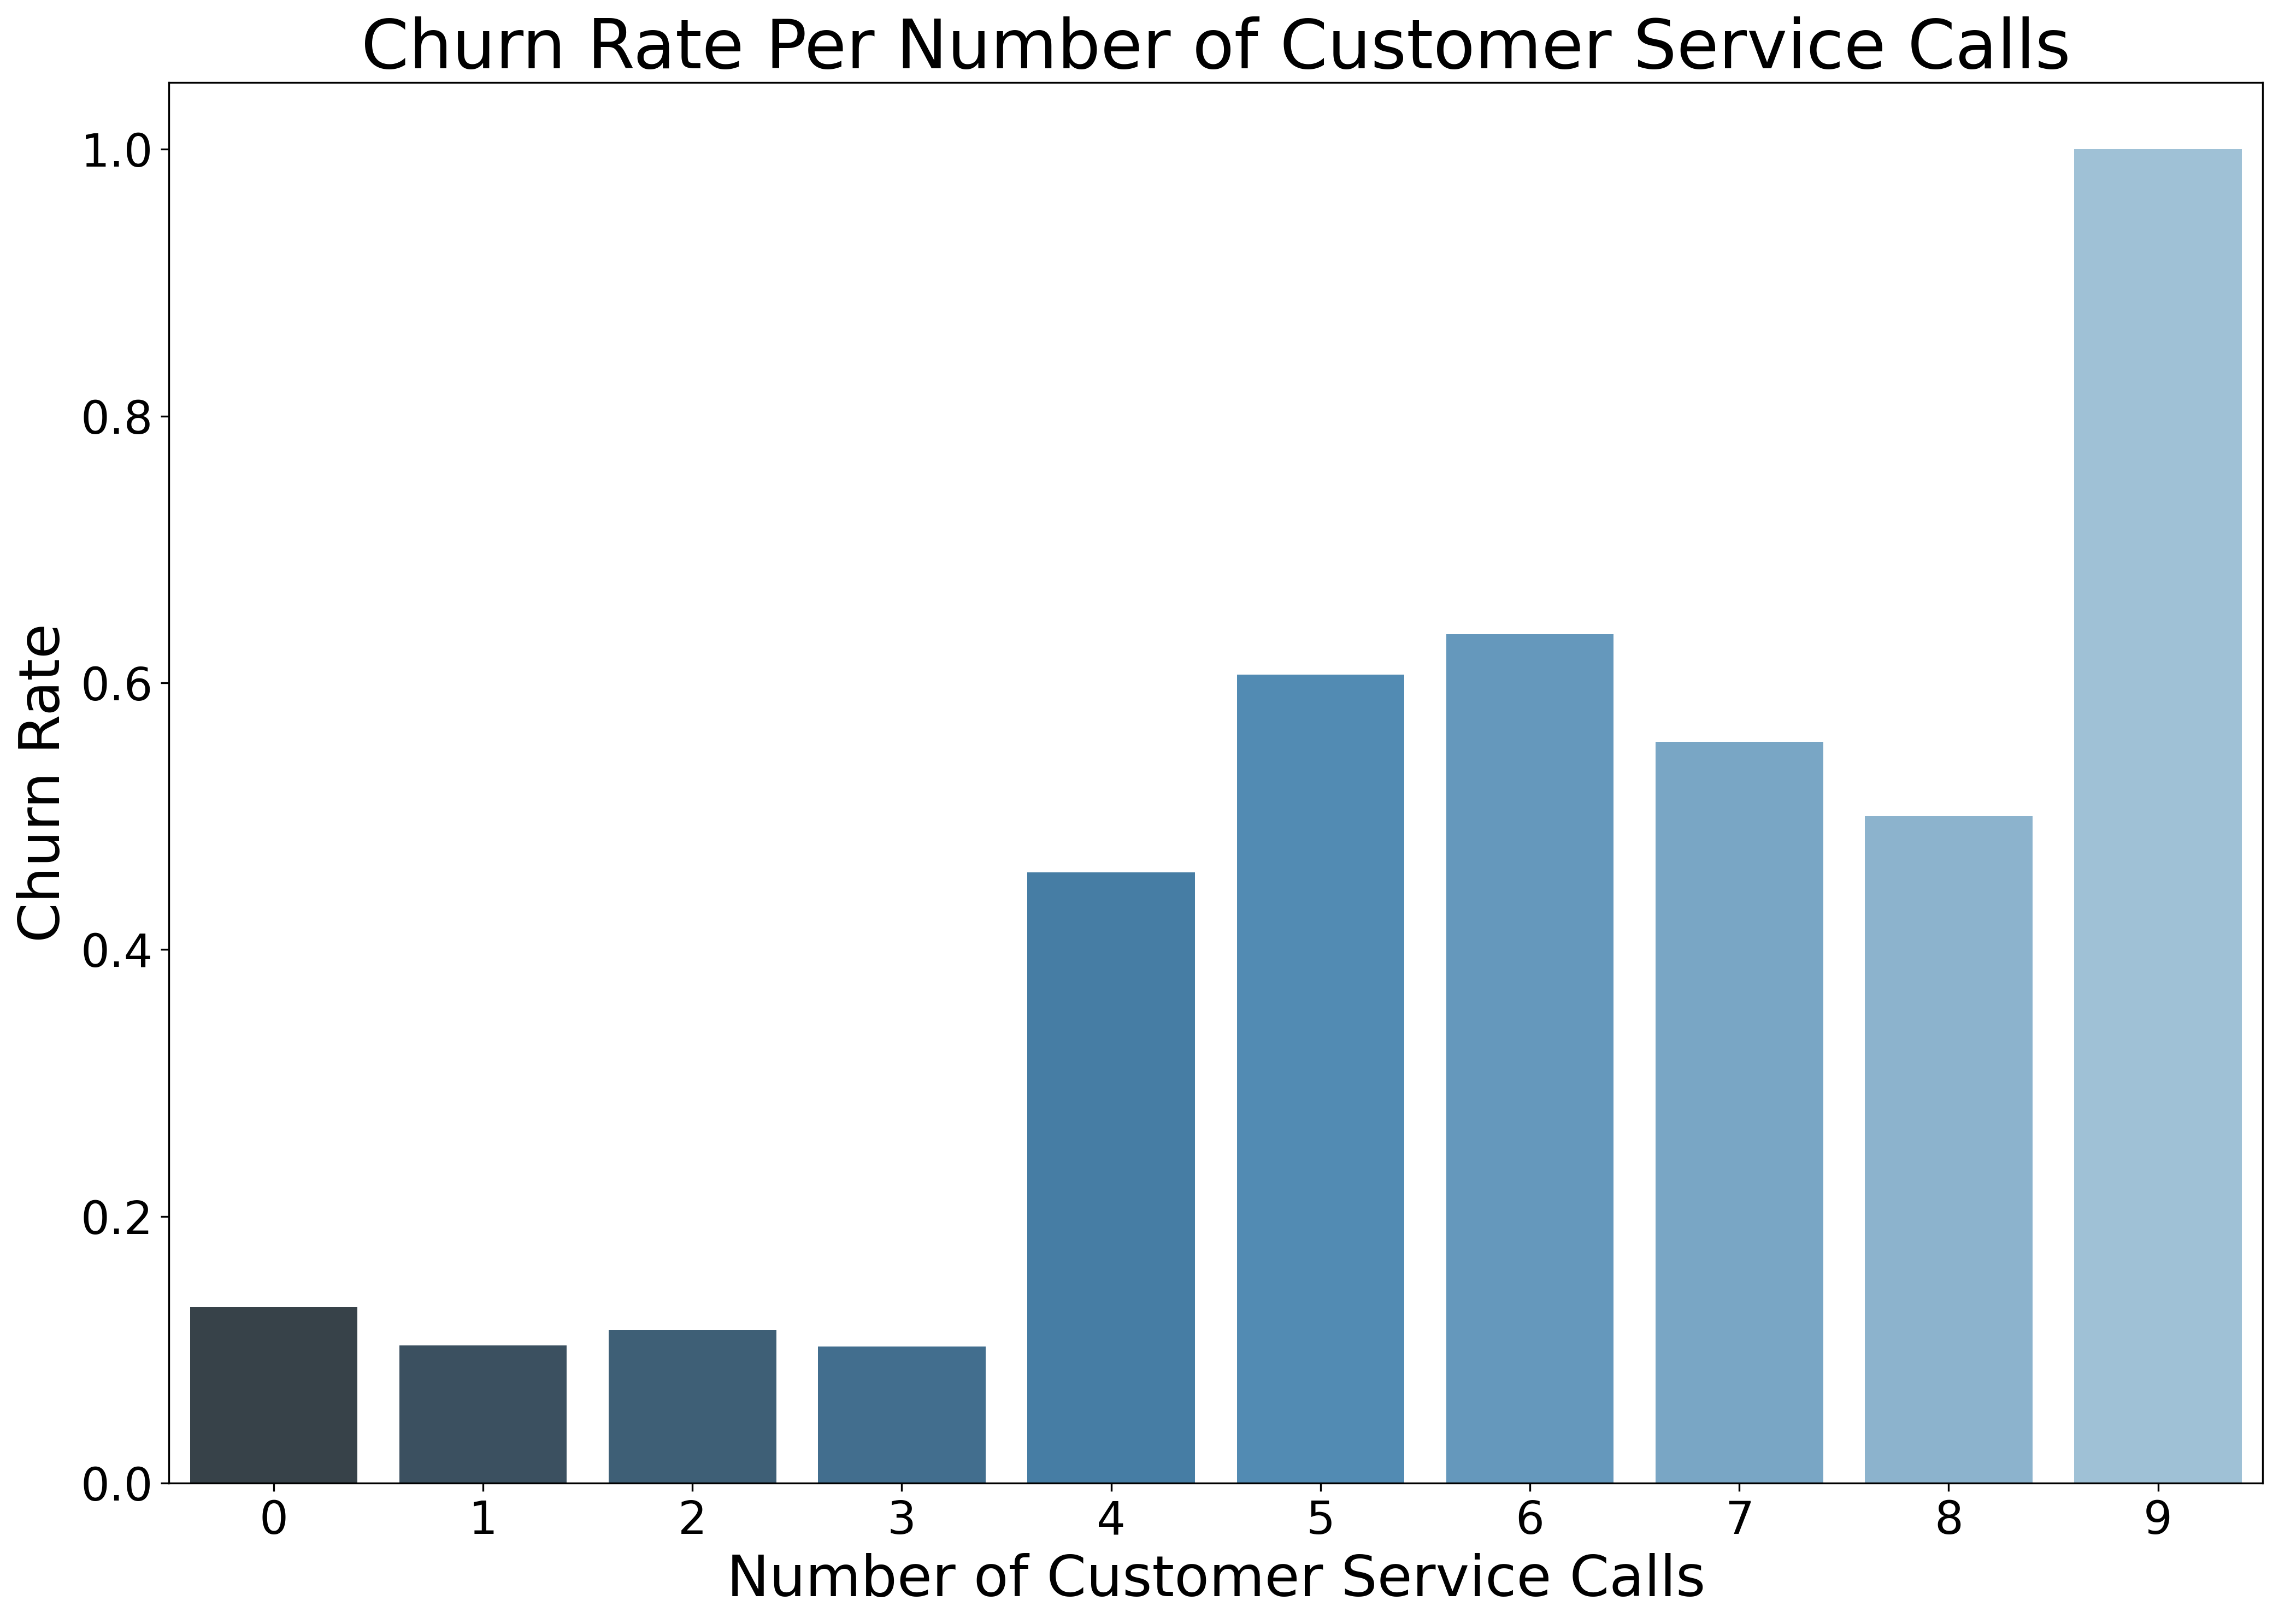

In [28]:
Image(filename = "figures/CustumorServiceCalls.png", width = 600, height = 300)

The Churn rate greatly increased for people who were payed 40-60 dollars for day charges.

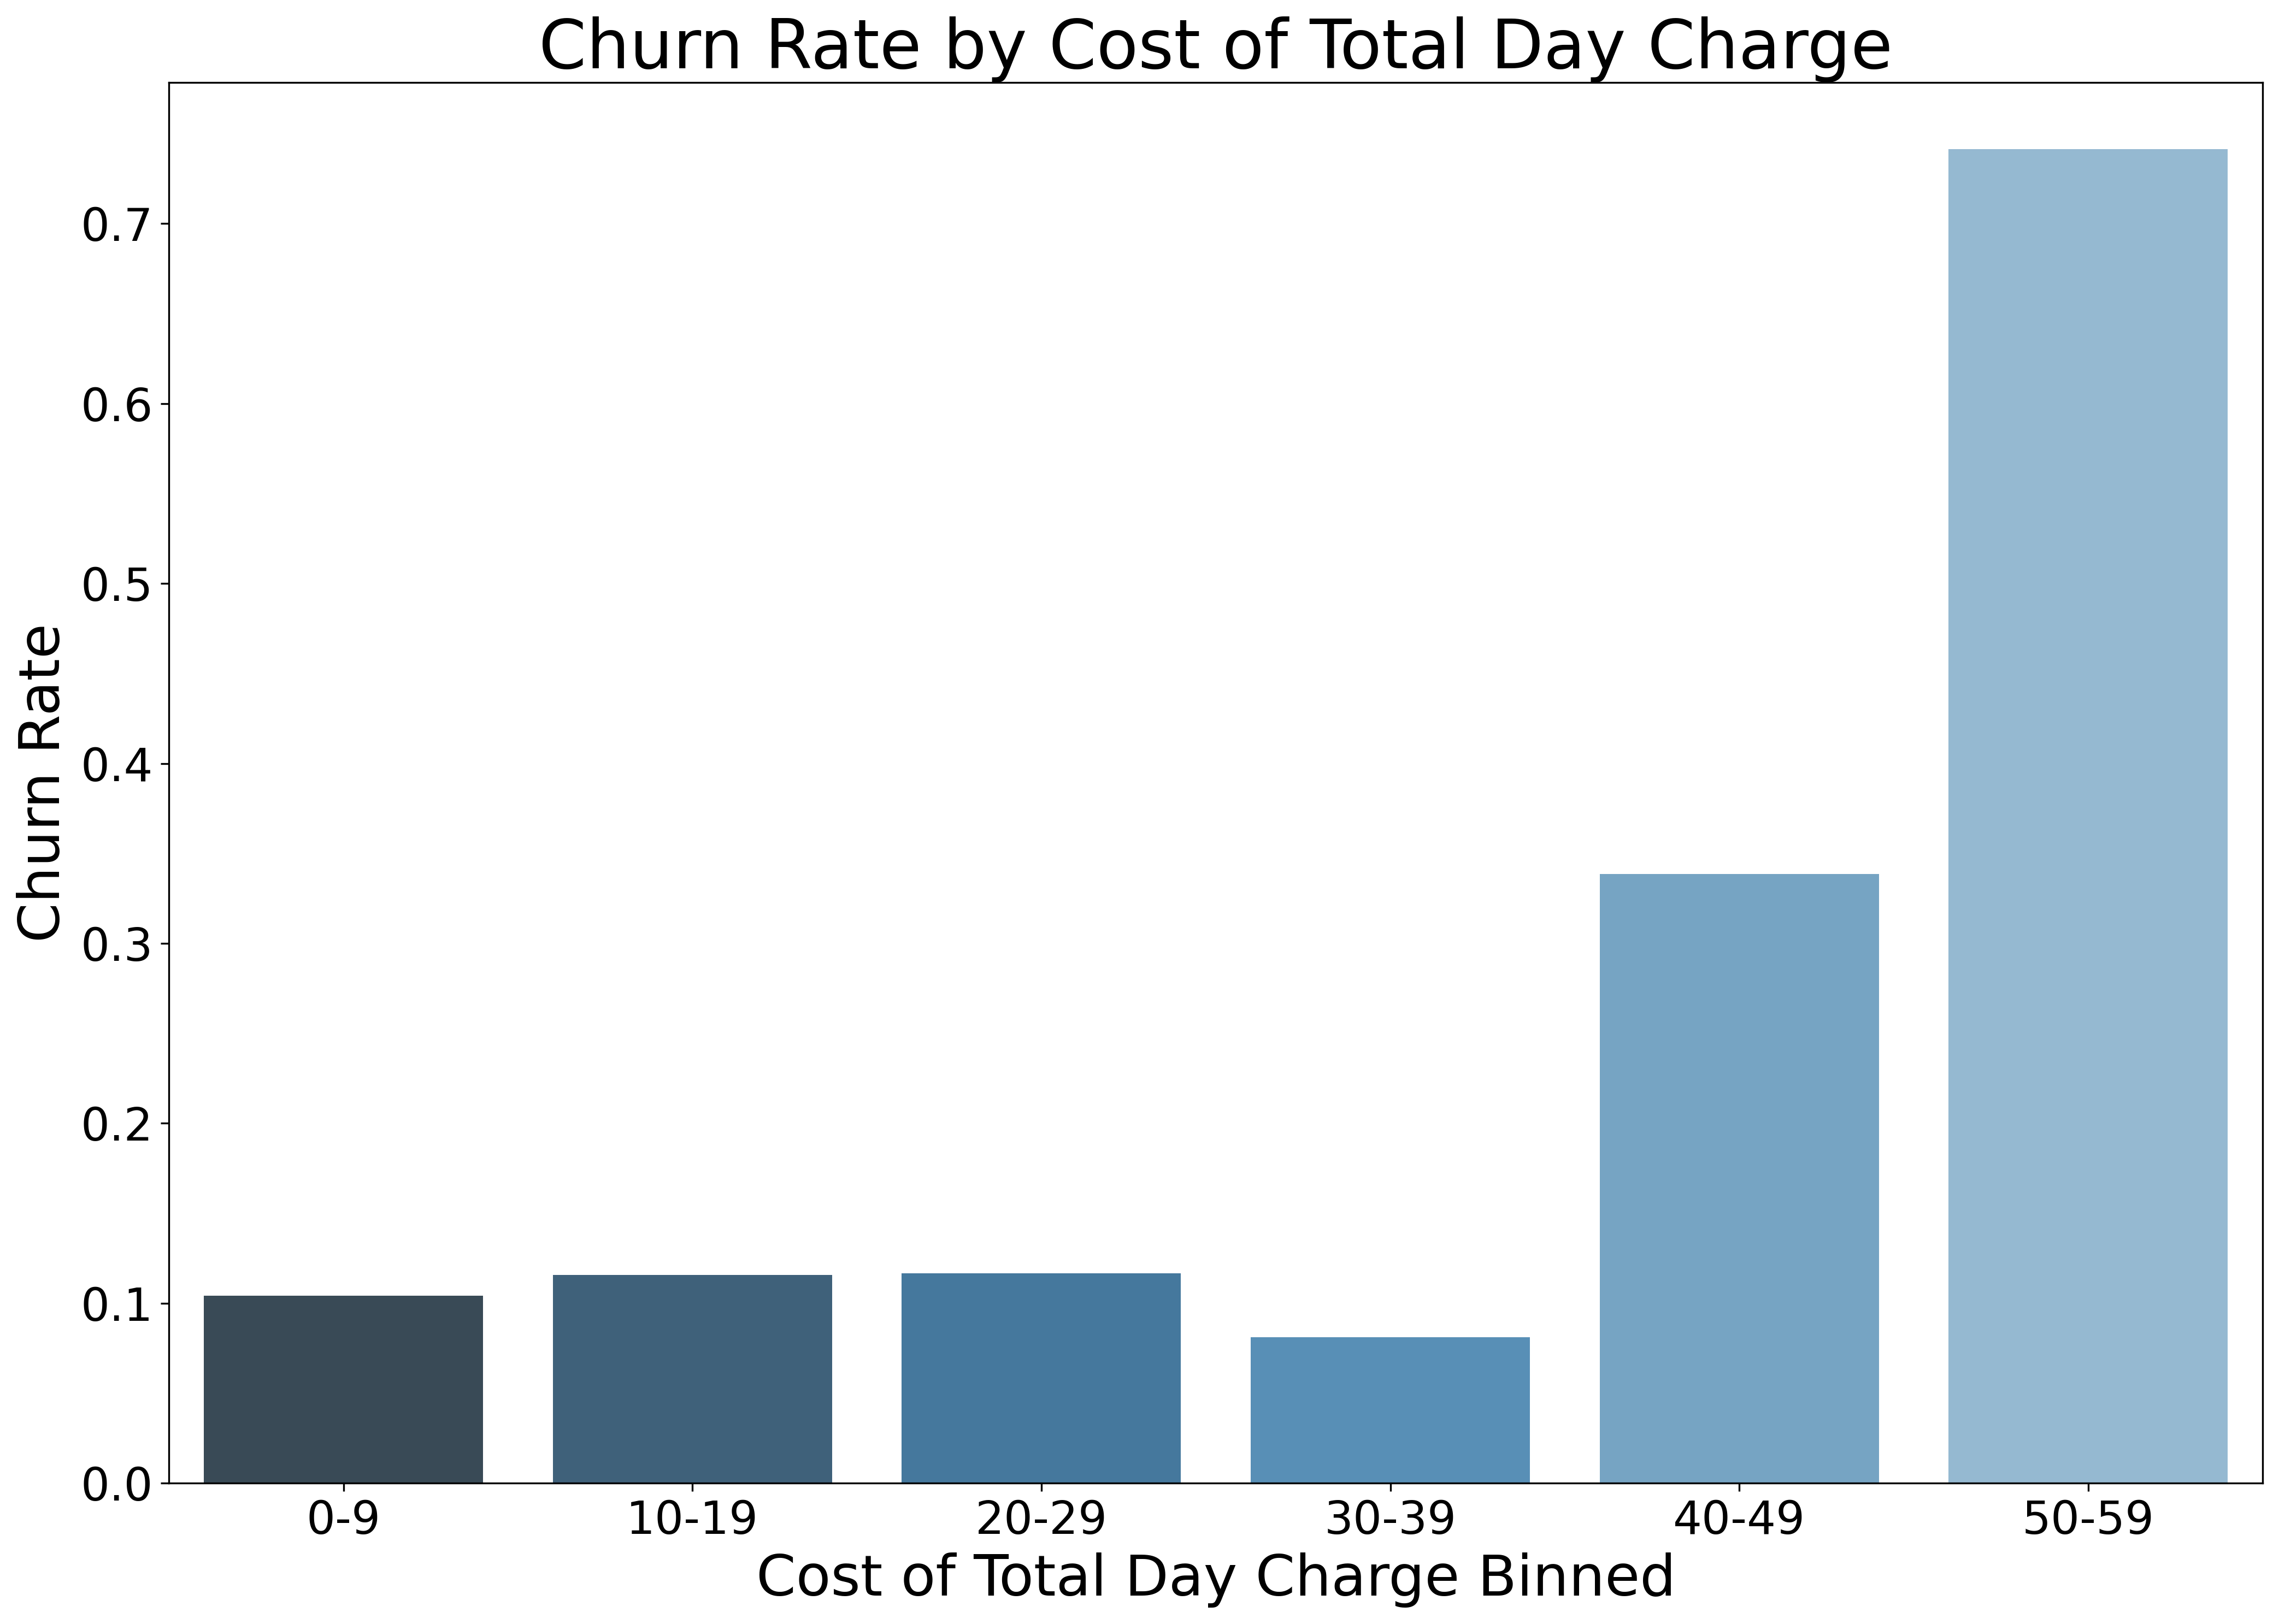

In [29]:
Image(filename = "figures/CostDayCharge.png", width = 600, height = 300)

# Early Modeling

In [40]:
# Created X variable and y variable from dataframe
df.drop(['area code', 'phone number'], axis = 1, inplace = True)
X = df.drop('churn', axis=1)
y = df['churn']

In [41]:
# creating test and train set to run models on
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = .2)

In [42]:
# Seperated columns so I could one hot encode. 
numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_features = X_train.select_dtypes(include='object').columns

## A basic pipeline was created to:
* one hot encode our catagorical features(state, Voicemail plan, International plan) <br>
* Standard Scalar<br>
* Smote to balance the class imbalance<br>
* Whatever model we want to run in it

In [64]:
# Pipline to run models through
pipe = Pipeline([
    ('oh', make_column_transformer(
    (OneHotEncoder(sparse = False, drop ='first'), categorical_features), remainder = 'passthrough')),
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state= 42)),
    ('log', LogisticRegression(random_state = 42))]) #We tried about 8 models total.

We ran different models through the pipeline to see how they performed on the train and test set. 
Below are the results of the test data shown in confusion matrix's. 

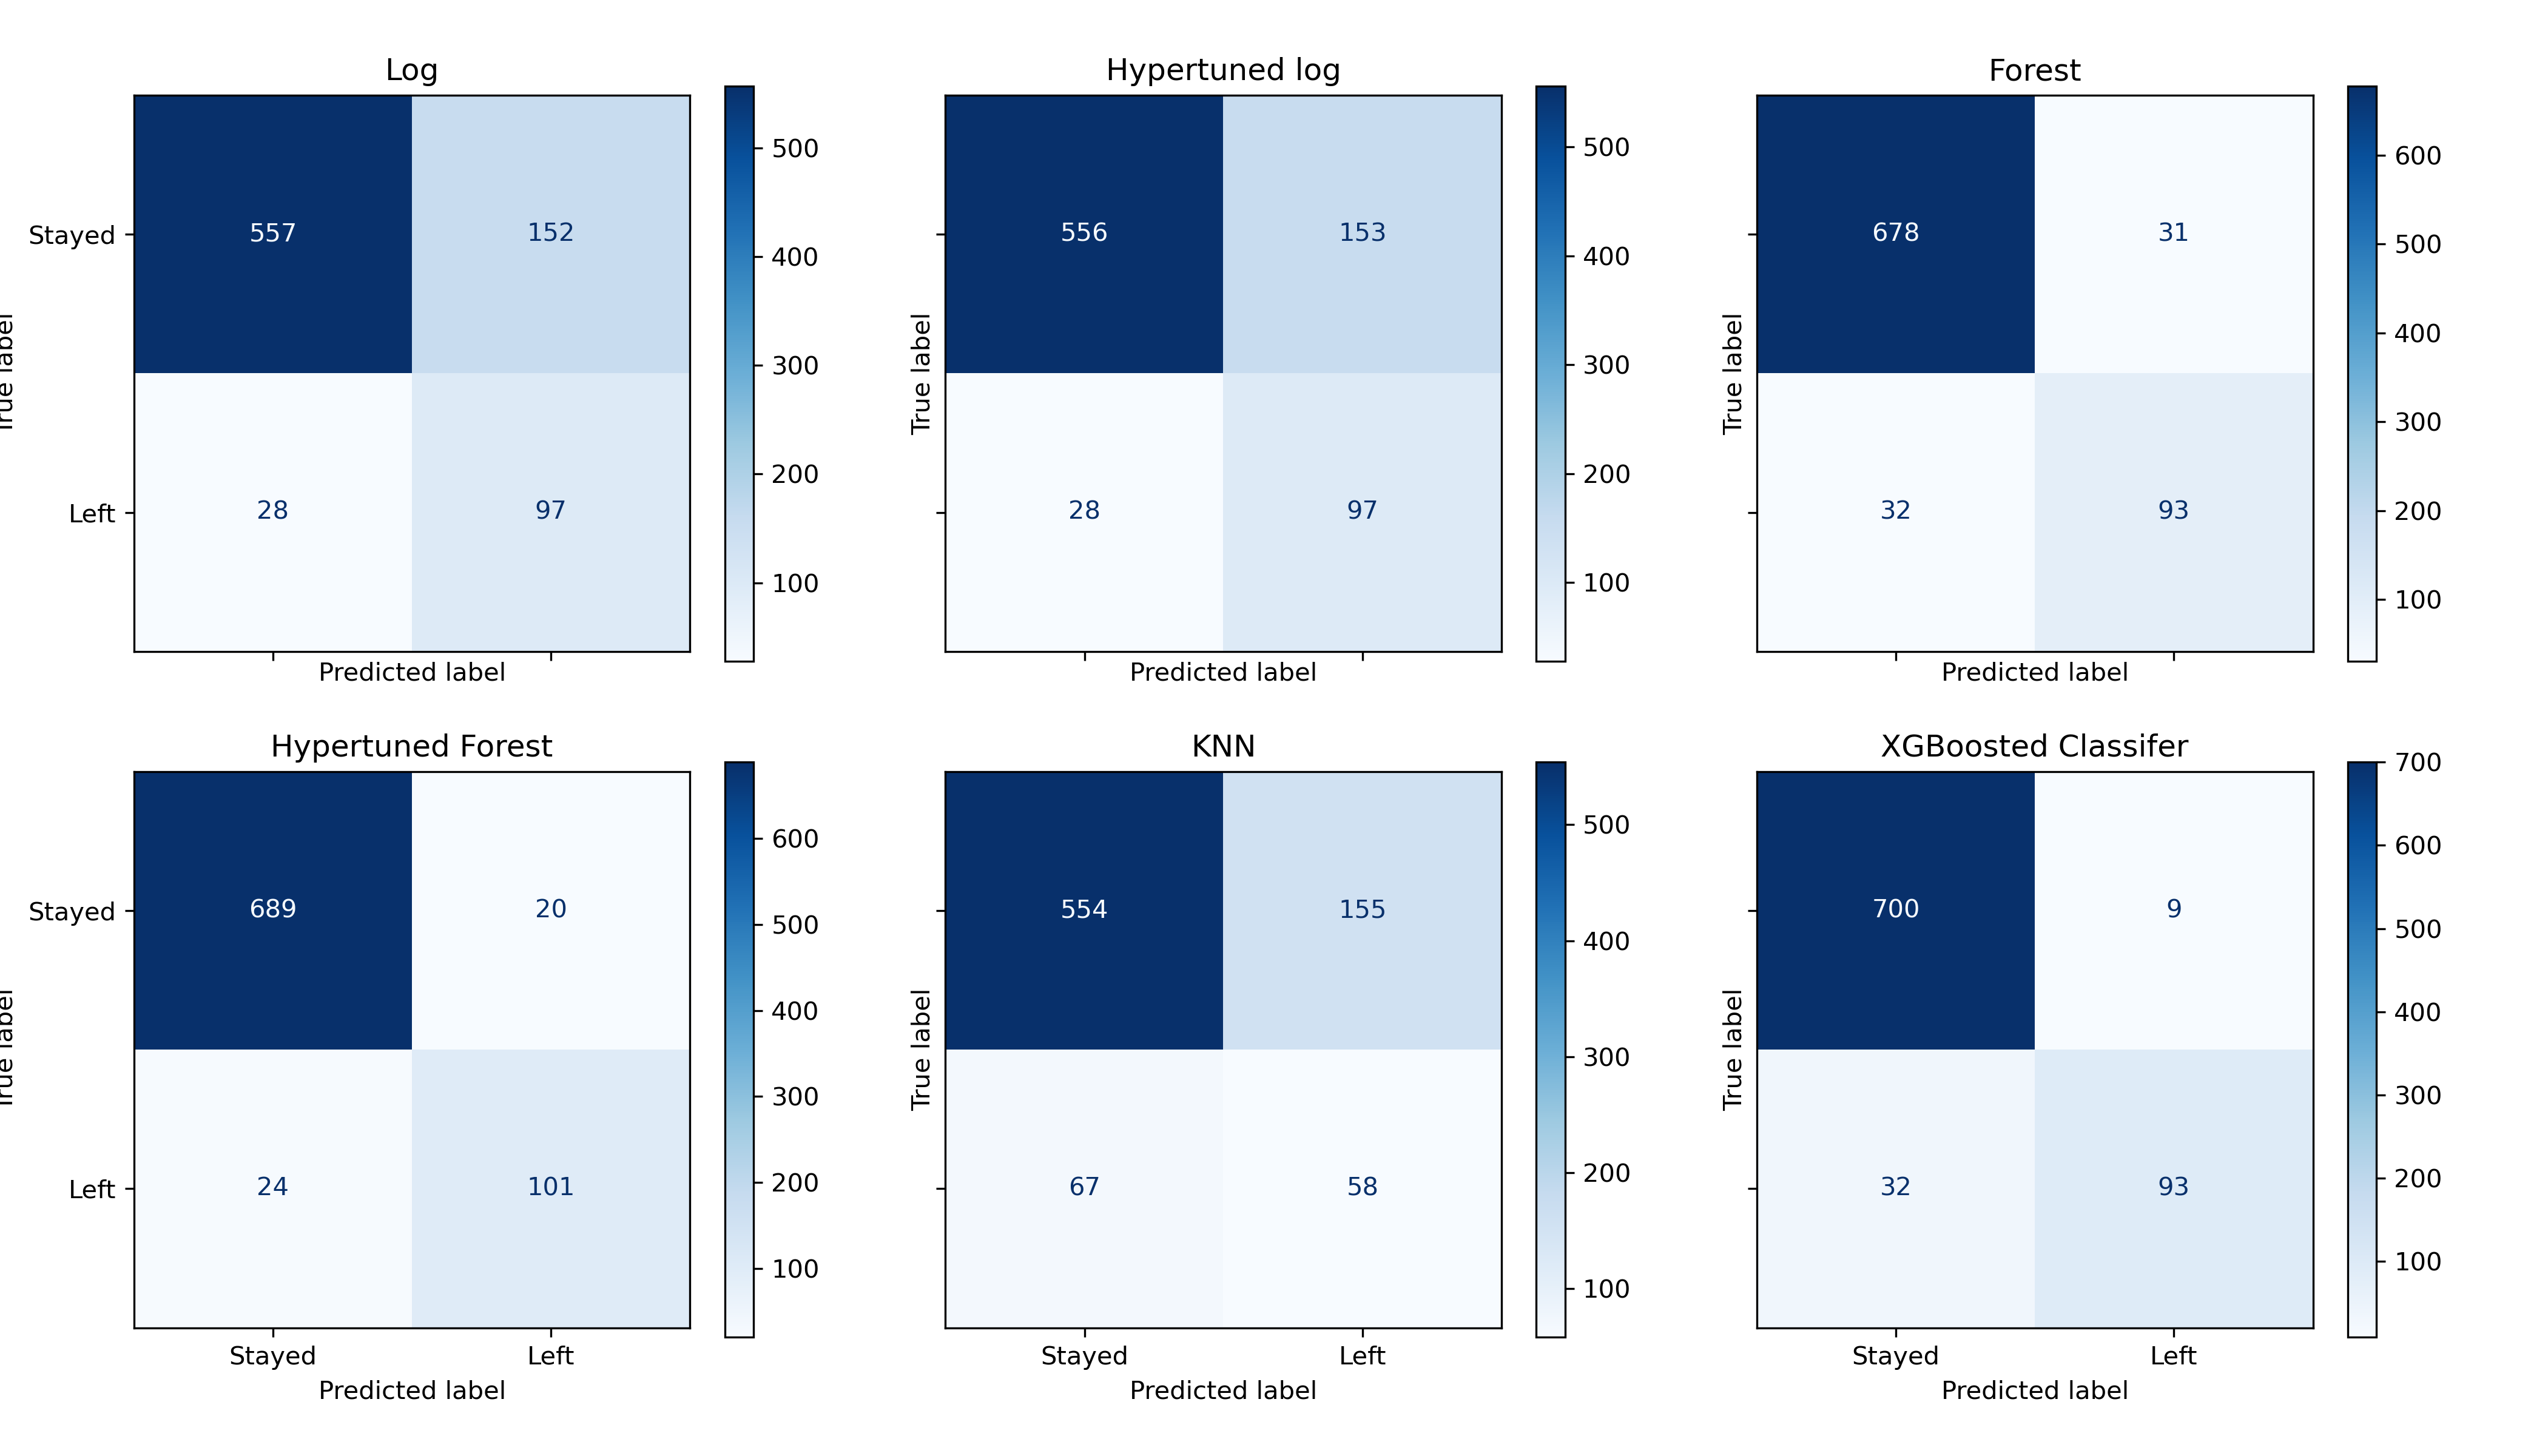

In [32]:
Image(filename = "figures/Early_models.png", width = 900, height = 450)

From the results it looks like XGboost and the Random forest have the best results. Since we are trying to maximize recall the trying to reduce the false negatives is the most important. The Hypertuned forest had 24 false negatives and the XG booested classifer had 32 false negatives.

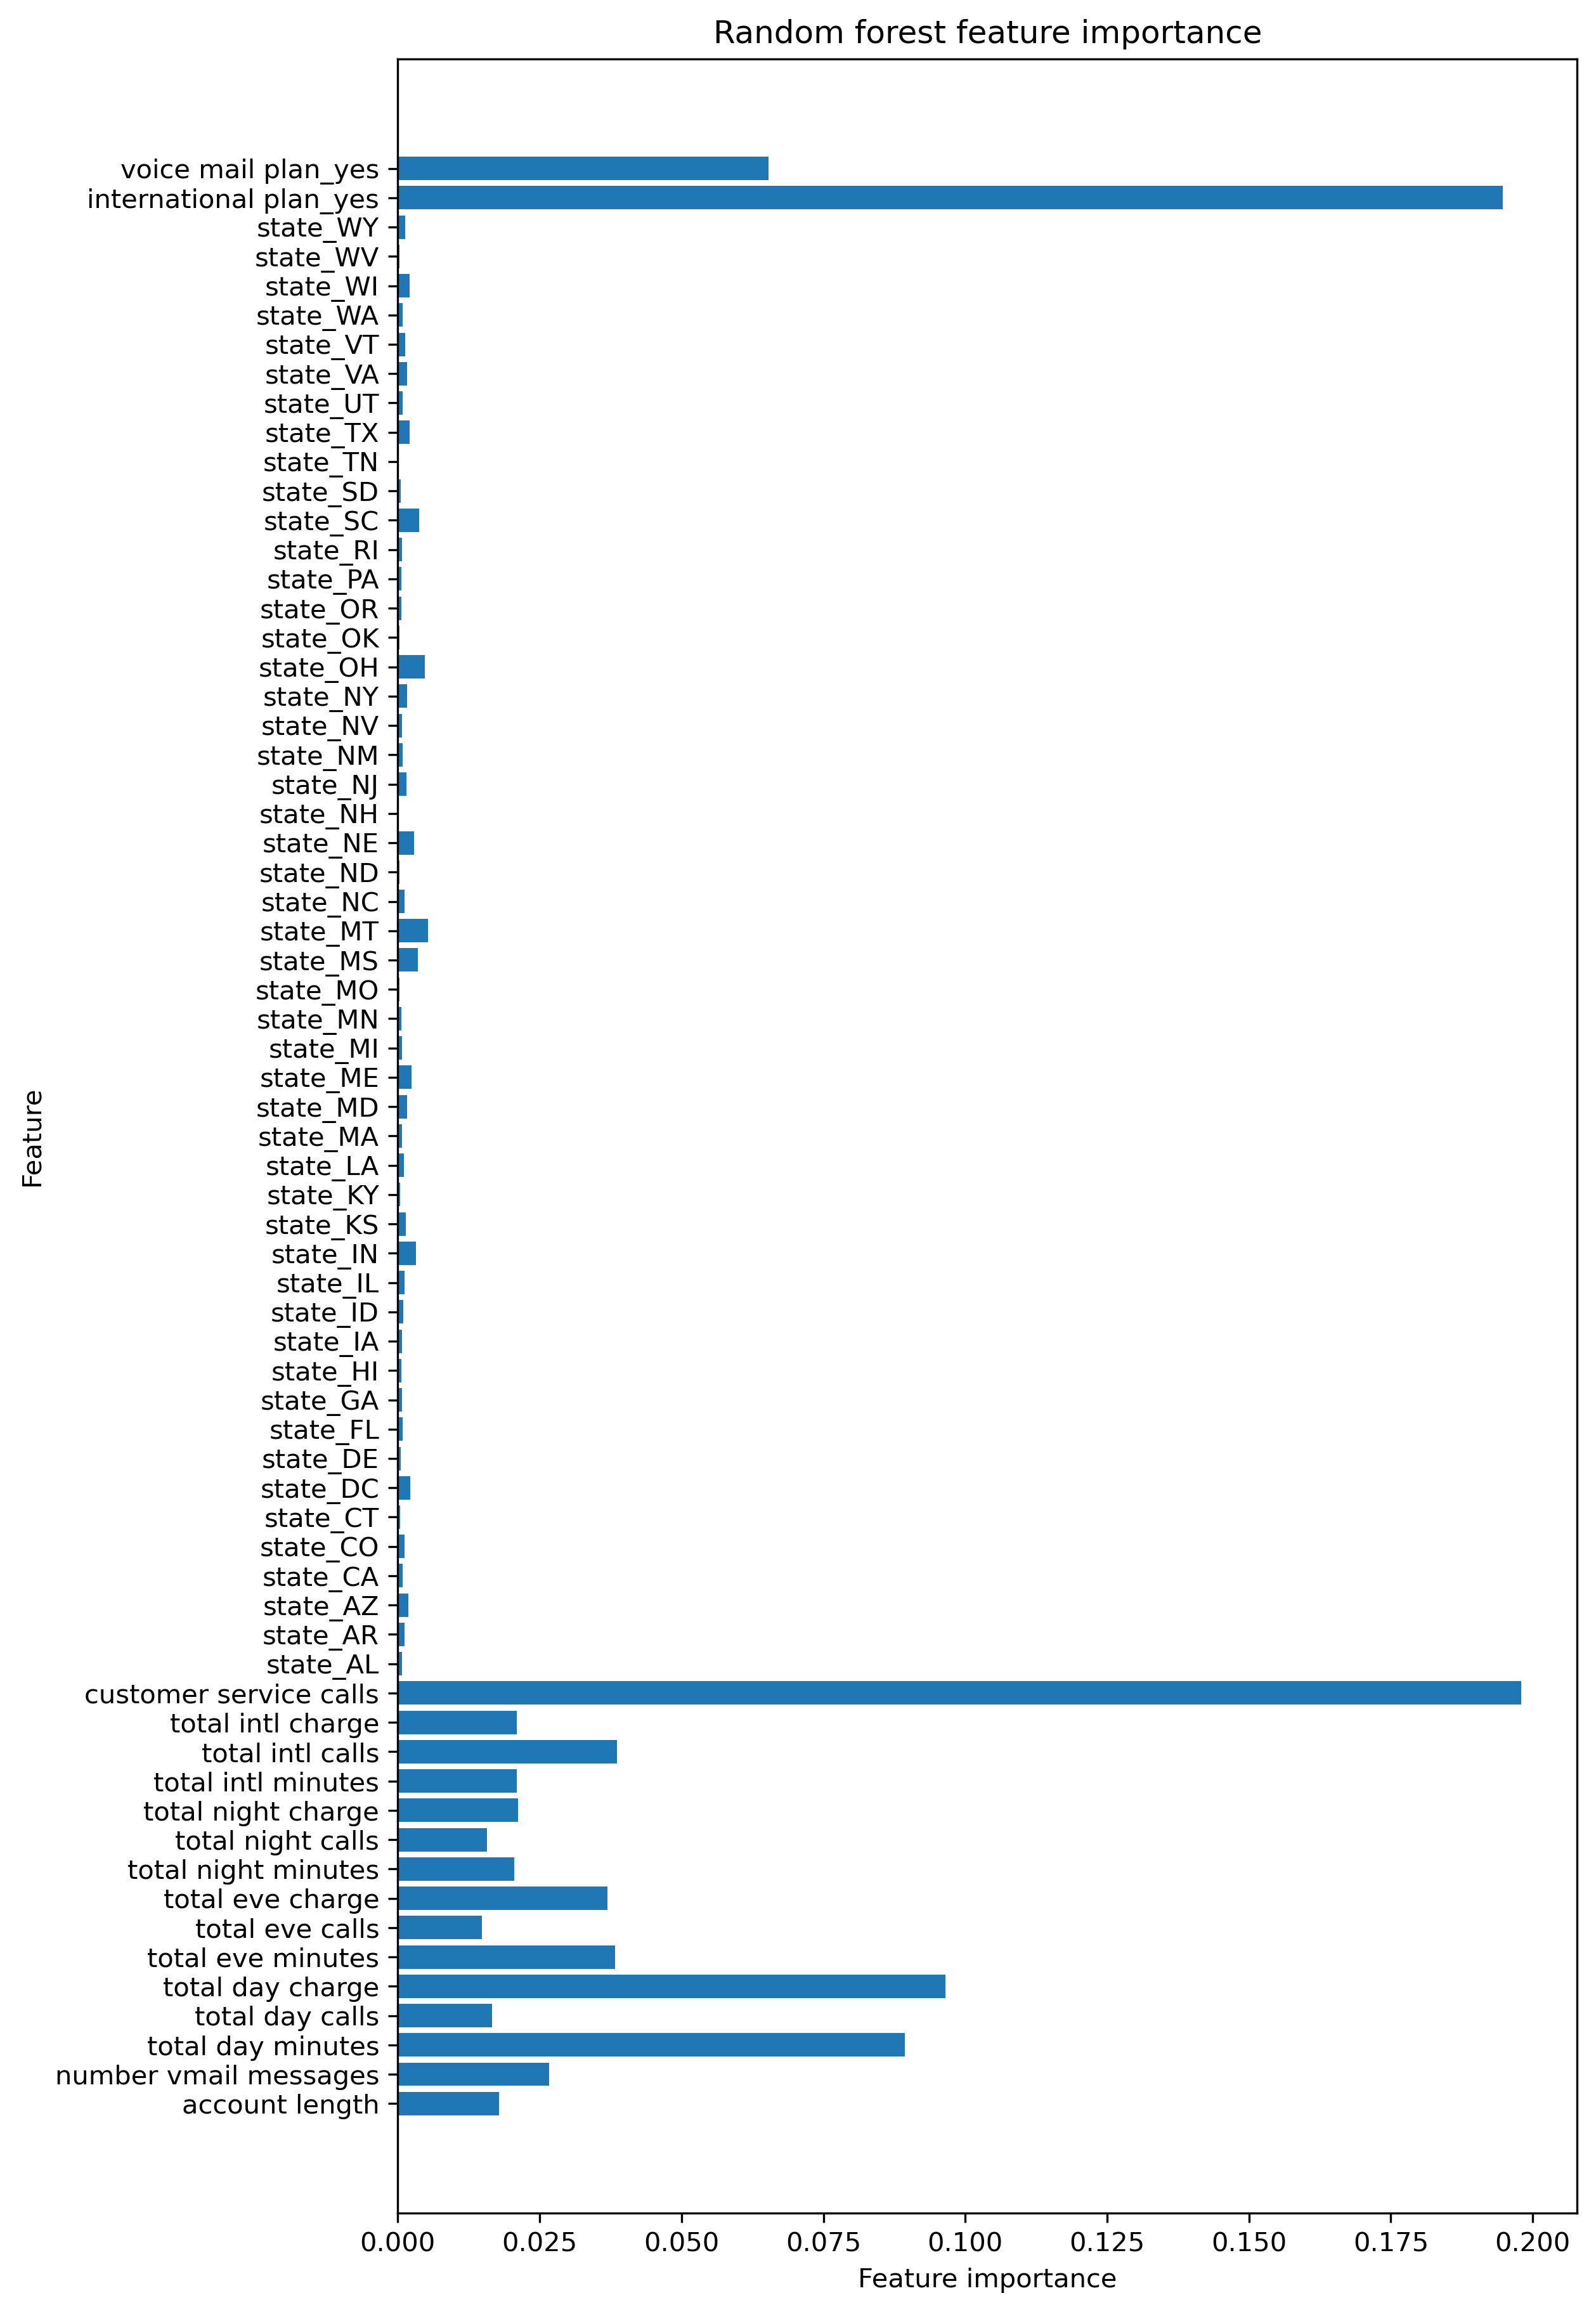

In [45]:
Image(filename = "figures/Feat.png", width = 900, height = 300)

The feature importance from random forest are picking up the same features we found in our EDA that were important. 
Our model will likely be predictive and inferential. Like wise there are some features that arent doing much or have a 1 to 1 correlation with other features that we could probably remove from model and still get the same results. 

# Final Modeling

We wanted to do grid searches on the RandomForest and XGboosted models because they performed the best on during the early modeling. 
We removed all the minute columns because they were directly correlated to the charge columns. We removed states because we noticed very little difference in model performance, but a big difference in computational time. 

### Setting up test train split

In [47]:
y = pd.read_csv('../../src/data/y_dataframe.csv', index_col= 0, squeeze= True)
X = pd.read_csv('../../src/data/X_dataframe.csv', index_col= 0)

In [48]:
# Features that werent impacting our performance but impacting computational time
X.drop(columns=['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes', 'state'], axis=1, inplace= True)

In [49]:
# Created a validation set so we never touched the testing data til the very end
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = .2)
X_t, X_val, y_t, y_val = train_test_split(X_train,y_train, random_state=42, test_size = .2)

In [54]:
# Seperated continous features and catagorical to get one hot encoded in the pipeline
numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_features = X_train.select_dtypes(include='object').columns

## Random Forest Model

Again we used a pipeline and combined it with a grid search to find the best parameters

In [55]:
grid_forest = {
    'rf__min_samples_split': [2, 3, 5], 
    'rf__n_estimators' : [100, 300],
    'rf__max_depth': [5, 15, 25, None],
    'rf__max_features': ['sqrt', 'log2', 10, .5]
}

### Best results were:
* max_depth = 5 
* max_features = .5 
* min_samples_split = 3
* n_estimators = 300 

In [56]:
pipe_forest = Pipeline([
    ('pp', make_column_transformer(
    (OneHotEncoder(sparse = False, drop ='first'), categorical_features), remainder = 'passthrough')),
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state= 42)),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 5, max_features = .5, min_samples_split = 3, n_estimators = 300 ))])

In [58]:
model_output(pipe_forest, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.899170645061178
The test Accuracy is: 0.9157303370786517
[[422  34]
 [ 11  67]]
              precision    recall  f1-score   support

       False       0.97      0.93      0.95       456
        True       0.66      0.86      0.75        78

    accuracy                           0.92       534
   macro avg       0.82      0.89      0.85       534
weighted avg       0.93      0.92      0.92       534



In [57]:
model_output(pipe_forest, X_train, X_test, y_train, y_test)

The Cross Val accuracy is: 0.9126055189047314
The test Accuracy is: 0.9295352323838081
[[535  31]
 [ 16  85]]
              precision    recall  f1-score   support

       False       0.97      0.95      0.96       566
        True       0.73      0.84      0.78       101

    accuracy                           0.93       667
   macro avg       0.85      0.89      0.87       667
weighted avg       0.93      0.93      0.93       667



# XG Boosted Model

We did the same with the XG boosted classifier to see what the best parameters were. 

In [74]:
xg_param = {
    'xg__max_depth': [4,6,10,20],
    'xg__learning_rate': [0.1, 0.01, 0.05],
    'xg__n_estimators': [300, 500],
    'xg__gamma': list(np.arange(0, .35, .05))
}

### Best resuts were:
* learning_rate = 0.01
* max_depth = 4 
* n_estimators = 500
* gamma = 0.3 

In [61]:
pipe_xg = Pipeline([
    ('pp', make_column_transformer(
    (OneHotEncoder(sparse = False, drop ='first'), categorical_features), remainder = 'passthrough')),
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state= 42)),
    ('xg', XGBClassifier(random_state = 42, learning_rate = 0.01, max_depth = 4, n_estimators = 500, gamma = 0.3))])

In [62]:
model_output(pipe_xg, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9273020212225062
The test Accuracy is: 0.9288389513108615
[[433  23]
 [ 15  63]]
              precision    recall  f1-score   support

       False       0.97      0.95      0.96       456
        True       0.73      0.81      0.77        78

    accuracy                           0.93       534
   macro avg       0.85      0.88      0.86       534
weighted avg       0.93      0.93      0.93       534



In [63]:
model_output(pipe_xg, X_train, X_test, y_train, y_test)

The Cross Val accuracy is: 0.9347378874937929
The test Accuracy is: 0.9490254872563718
[[548  18]
 [ 16  85]]
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       566
        True       0.83      0.84      0.83       101

    accuracy                           0.95       667
   macro avg       0.90      0.90      0.90       667
weighted avg       0.95      0.95      0.95       667



# Decision

The random forest had the best recall score of .86 on the validation set, but performed worse than the XGBoosted classifier on the Test data overall. The XBGoosted had the highest recall, precision, and accuracy on the test data which is why we chose it as our final model. 

For seeing more iterations on how we came to this final model go [Hunter2 notebook](../exploratory/Hunter2.ipynb).

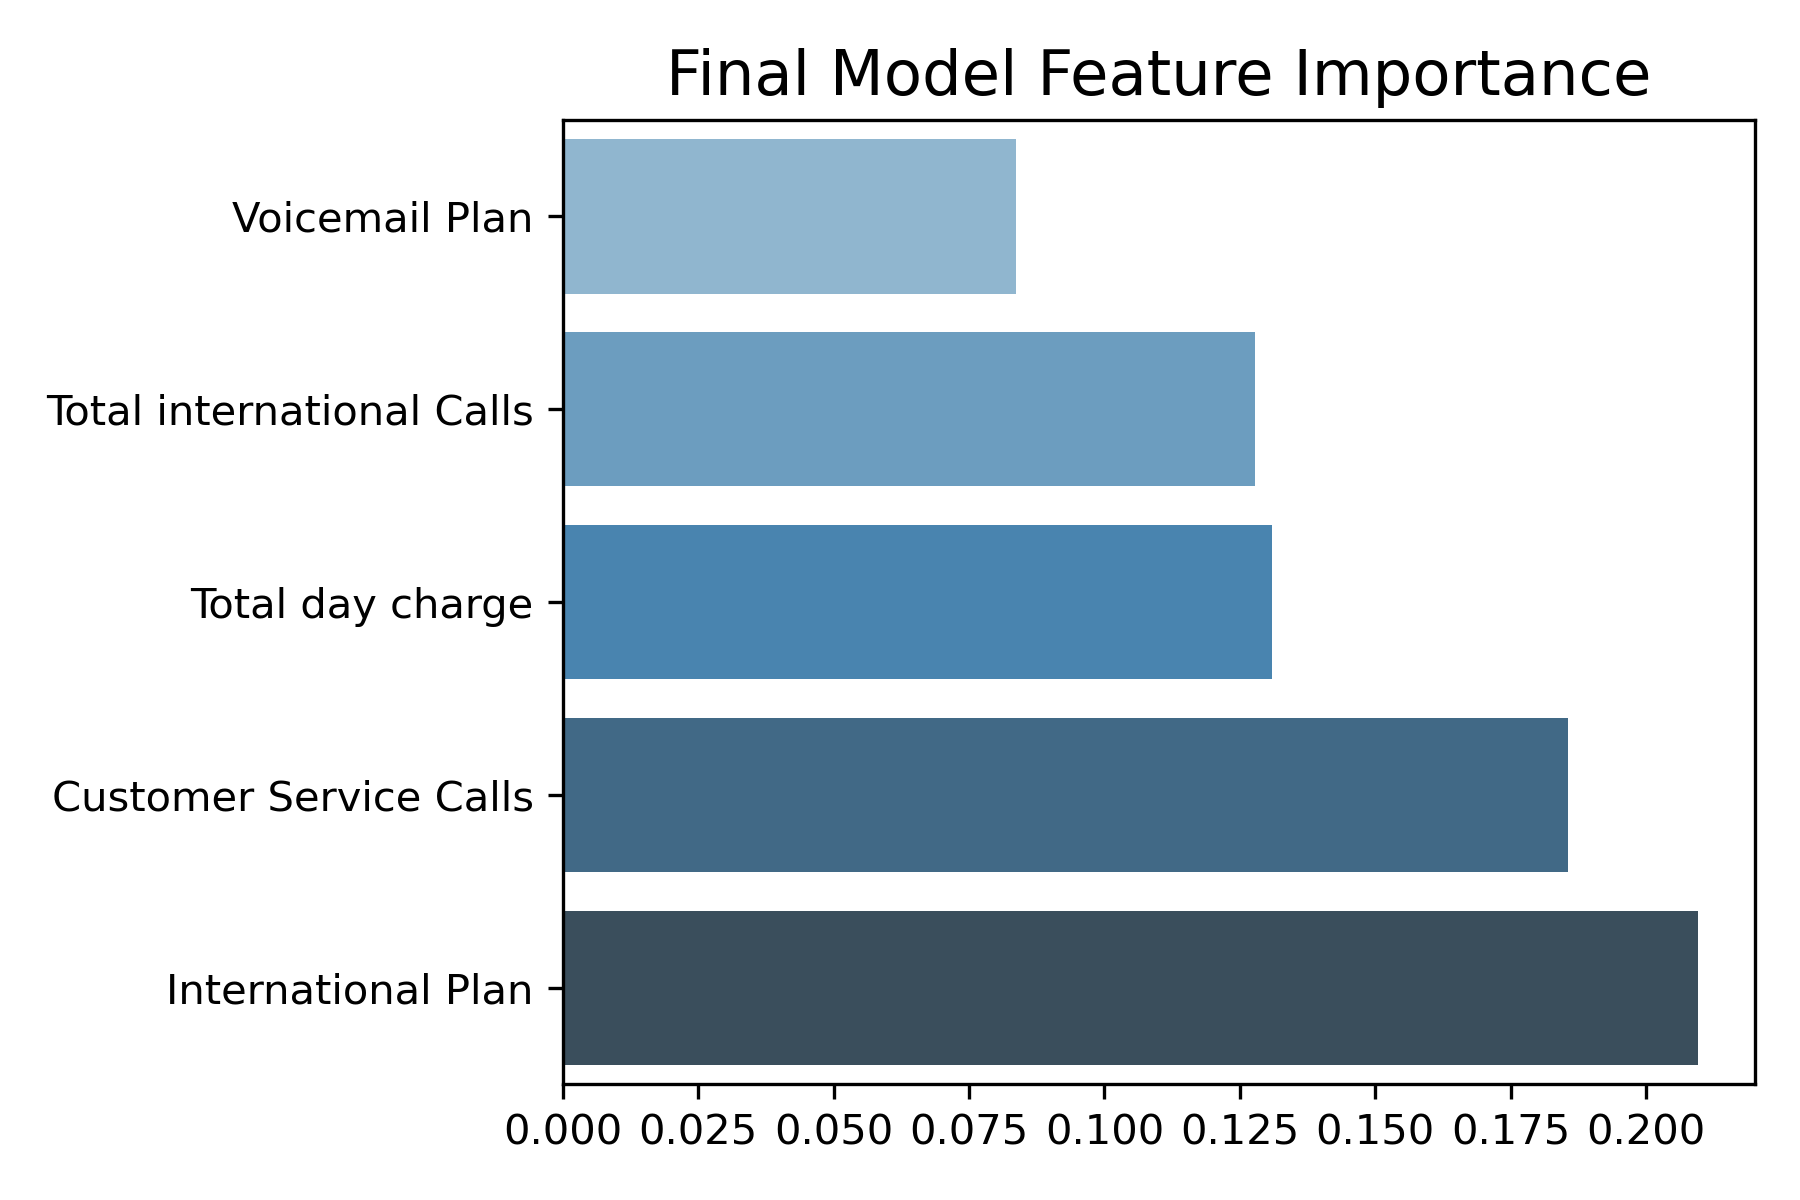

In [70]:
Image(filename = "figures/Final_model_features.png", width = 900, height = 300)

# Conclusion

The best model we were able to find that would produce the best Recall score was an XGBooster Classifier. 
This model gave us a Recall of 84% meaning out of the 101 people that left in our test data we were able to predict 85 of them correctly. 
Not only did our model give us a good Recall score, but a Precision of 97%(towards the False catagory). This means out of the 566 people stayed our model was able to predict 548 correctly. And the fact our model performed about the same on the test and train set gives it validity. 

### The 5 top Feature importance of our model was:
* International plan - A person is more likely to leave if they have an International Plan
* Customer Service Calls- The higher rate of customer service calls the more likey they will leave (At 4 calls Churn rate increases significantly)
* Total day charge - The higher amount a person is charge for the day the more likey they will leave (At 40$ Charge Churn rate increases significantly)
* Total International Calls - As international call increase so do churn rate. 
* Voicemail plan - You are more likely to leave if you dont have a voicemail plan

The company should investigate what is causing customers who have International plans to leave. We imagine it is due to a competitor who offers better international plan deal or they found other ways to communicate international for free. The higher customer service calls makes sense and should looked into why those people are making those calls that are leaving. The total day charge is a flat rate per minute so maybe offer a lower rate for people who use more minutes. 